In [1]:
from src.visualise import settings
from src.visualise.plot import plot_data
from src.data.paths import project_dir
from src.data.analysis import read_tiff_img, Circle, create_circular_mask
from src.data.detector import find_circle_hough_method

import numpy as np
import matplotlib.pyplot as plt

In [2]:
raw_path = project_dir / 'data' / 'raw' / '2024-02-20'
raw_path.exists()

True

In [3]:
lv_paths = sorted(list(raw_path.glob('**/*lv/**/*tif')))
lv_paths[:5]

[PosixPath('/home/grzanka/workspace/osl_mb_foils/data/raw/2024-02-20/01lv/Default/img_channel000_position000_time000000000_z000.tif'),
 PosixPath('/home/grzanka/workspace/osl_mb_foils/data/raw/2024-02-20/02lv/Default/img_channel000_position000_time000000000_z000.tif'),
 PosixPath('/home/grzanka/workspace/osl_mb_foils/data/raw/2024-02-20/03lv/Default/img_channel000_position000_time000000000_z000.tif'),
 PosixPath('/home/grzanka/workspace/osl_mb_foils/data/raw/2024-02-20/04lv/Default/img_channel000_position000_time000000000_z000.tif'),
 PosixPath('/home/grzanka/workspace/osl_mb_foils/data/raw/2024-02-20/05lv/Default/img_channel000_position000_time000000000_z000.tif')]

In [4]:
lv_path_test = lv_paths[1]
lv_path_test.exists(), lv_path_test

(True,
 PosixPath('/home/grzanka/workspace/osl_mb_foils/data/raw/2024-02-20/02lv/Default/img_channel000_position000_time000000000_z000.tif'))

In [5]:
lv_data = read_tiff_img(lv_path_test, border_px=0)

(<Figure size 1600x1000 with 2 Axes>, <Axes: >)

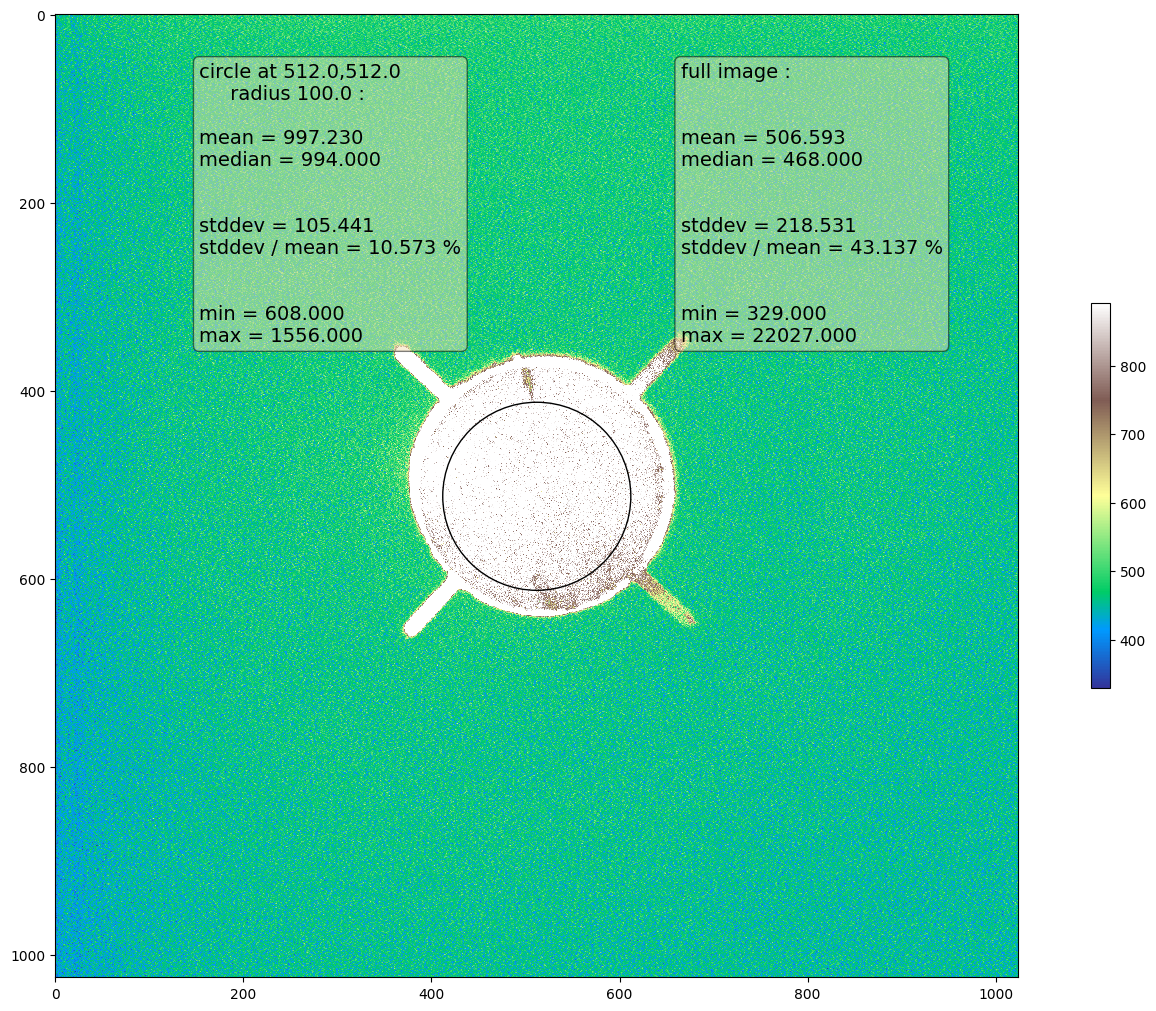

In [6]:
small_circle = Circle(x=lv_data.shape[0]/2,y=lv_data.shape[0]/2,r=100)
plot_data(lv_data, path='', circle_px=small_circle)

In [7]:
import numpy.typing as npt
import logging
def img_for_circle_detection(data: npt.NDArray, r: float = 100, nsigma: float = 2., old_method : bool = False) -> npt.NDArray:
    logging.info('Before setting threshold ' +
                 f'min {np.nanmin(data)}, mean {np.nanmean(data):3.3f}, max {np.nanmax(data)}')
    output = np.zeros(shape=data.shape, dtype='uint8')

    circle_inside_det = Circle(x=data.shape[0]/2,y=data.shape[0]/2,r=r)
    mask_inside_det = create_circular_mask(data, small_circle)
    upper_threshold = np.mean(data, where=mask_inside_det) + nsigma * np.std(data, where=mask_inside_det)
    lower_threshold = np.mean(data, where=mask_inside_det) - nsigma * np.std(data, where=mask_inside_det)

    if old_method:
        lower_threshold = np.percentile(data, 95)
        upper_threshold = np.max(data)
    print(lower_threshold, upper_threshold)
    
    output[(data > lower_threshold) & (data < upper_threshold)] = 255
    output[np.isnan(data)] = 255
    logging.info('After setting threshold ' +
                 f'min {np.min(output)}, mean {np.mean(output):3.3f}, max {np.max(output)}')
    return output
lv_for_detect = img_for_circle_detection(lv_data, nsigma=2)

786.3474575813707 1208.1117205705852


In [8]:
circle_inside_det = Circle(x=lv_data.shape[0]/2,y=lv_data.shape[0]/2,r=100)
mask_inside_det = create_circular_mask(lv_data, small_circle)
nsigma = 2
upper_threshold = np.mean(lv_data, where=mask_inside_det) + nsigma * np.std(lv_data, where=mask_inside_det)
lower_threshold = np.mean(lv_data, where=mask_inside_det) - nsigma * np.std(lv_data, where=mask_inside_det)

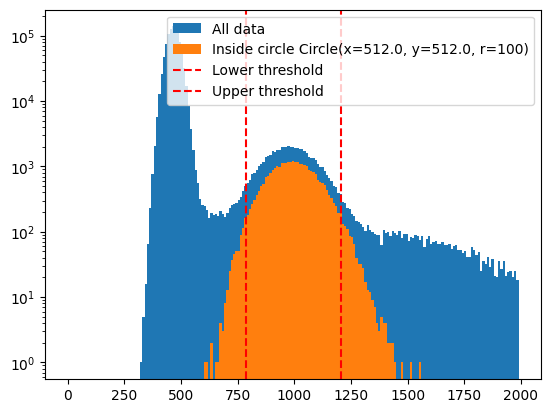

In [9]:
bins = np.arange(start=0, stop=2000, step=10)
plt.hist(lv_data.flatten(), bins=bins, label="All data");
plt.hist((lv_data[mask_inside_det]).flatten(), bins=bins, label=f"Inside circle {circle_inside_det}");
plt.axvline(lower_threshold, color='r', linestyle='--', label='Lower threshold');
plt.axvline(upper_threshold, color='r', linestyle='--', label='Upper threshold');
plt.yscale('log');
plt.legend();

(<Figure size 1600x1000 with 2 Axes>, <Axes: >)

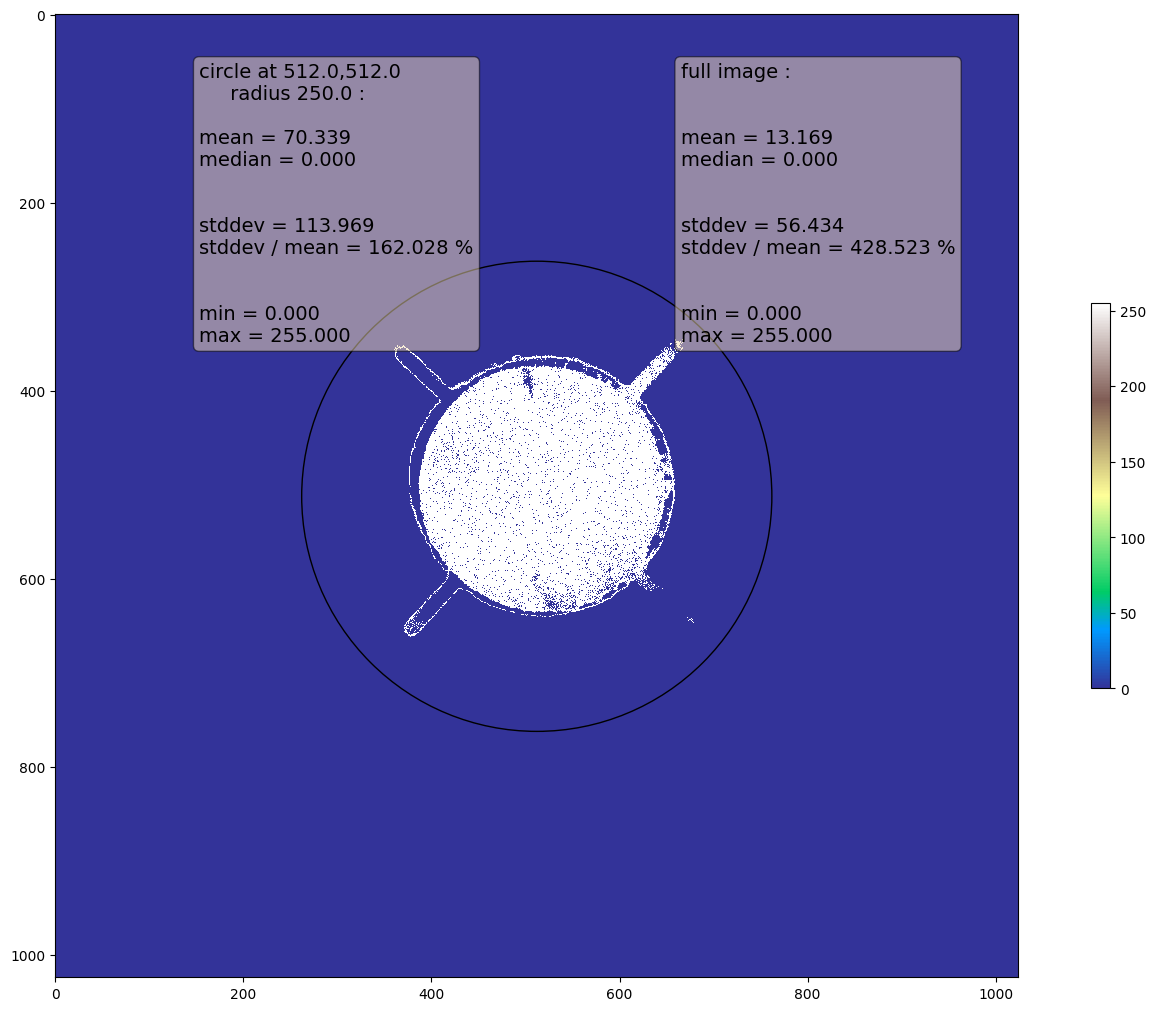

In [10]:
plot_data(lv_for_detect, path='', clip=False)

In [11]:
import cv2
def find_circle_hough_method(data: npt.NDArray) -> Circle:
    logging.info(f'Detector circle not provided, calculating with Hough method')
    hough_results = cv2.HoughCircles(data, cv2.HOUGH_GRADIENT, dp=1, minDist=10000, param1=10, param2=0.9, minRadius=100, maxRadius=200)
    logging.info(f'Hough method results {hough_results}')
    result_circle = Circle()
    if hough_results is None:
        print("No detector found by Hough method")
    elif hough_results.shape[0] > 1:
        print("More than one shape found by Hough method")
    elif hough_results.shape[0] == 1 and hough_results.shape[1] == 1:
        # explicit conversion to float is needed to ensure proper JSON serialisation
        # hough_results is a numpy float32 array and float32 is not JSON serialisable
        result_circle = Circle(
            x=float(hough_results[0, 0, 0]),
            y=float(hough_results[0, 0, 1]),
            r=float(hough_results[0, 0, 2]),
        )
        logging.info(f'Detected circle {result_circle}')
    return result_circle
c = find_circle_hough_method(lv_for_detect)
c

Circle(x=514.5, y=499.5, r=126.30000305175781)

(<Figure size 1600x1000 with 2 Axes>, <Axes: >)

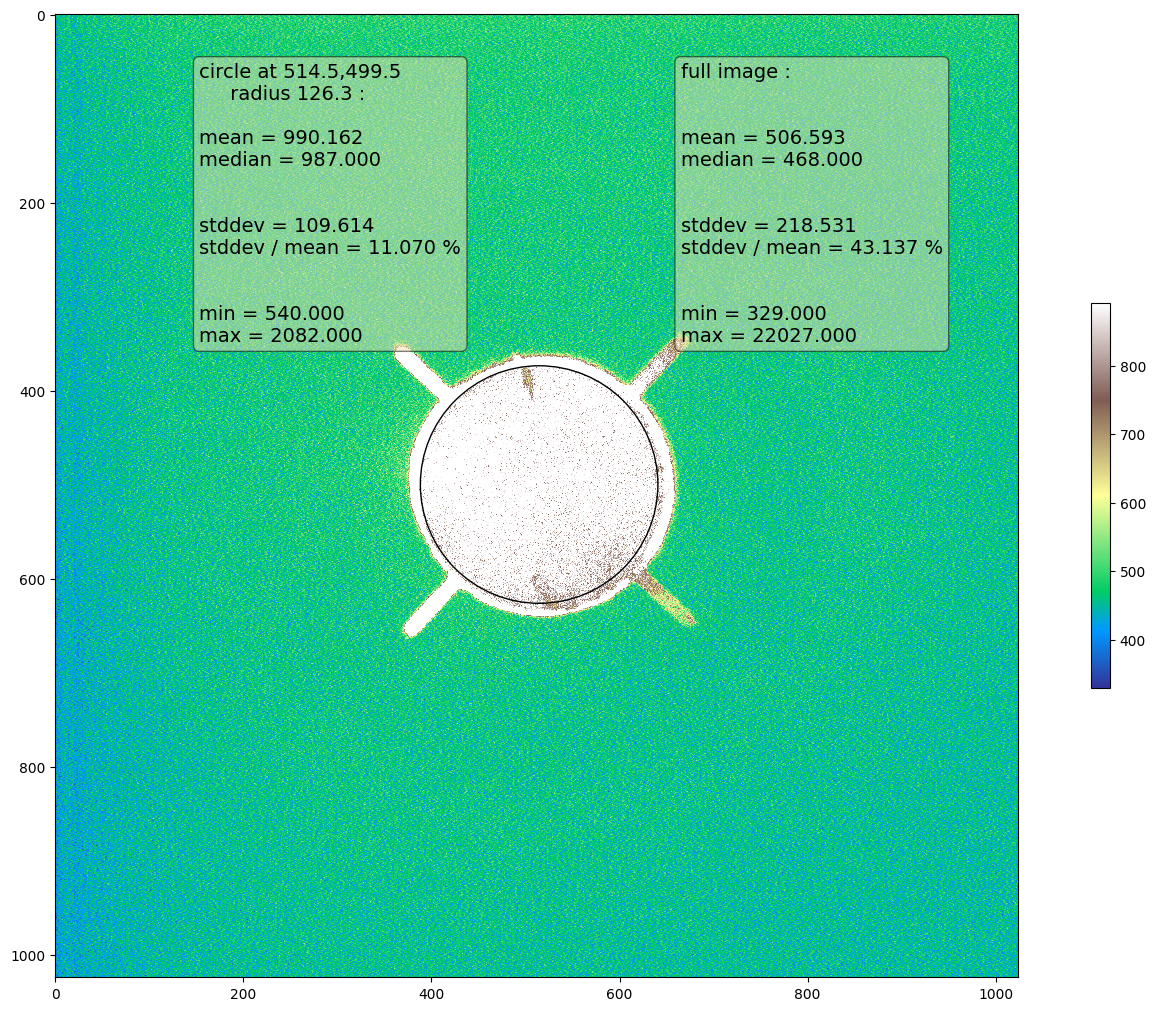

In [12]:
plot_data(lv_data, path='', circle_px=c)

In [13]:
c_old = find_circle_hough_method(img_for_circle_detection(lv_data, nsigma=2, old_method=True))
c_old, c

891.0 22027


(Circle(x=519.5, y=501.5, r=137.89999389648438),
 Circle(x=514.5, y=499.5, r=126.30000305175781))

(<Figure size 1600x1000 with 2 Axes>, <Axes: >)

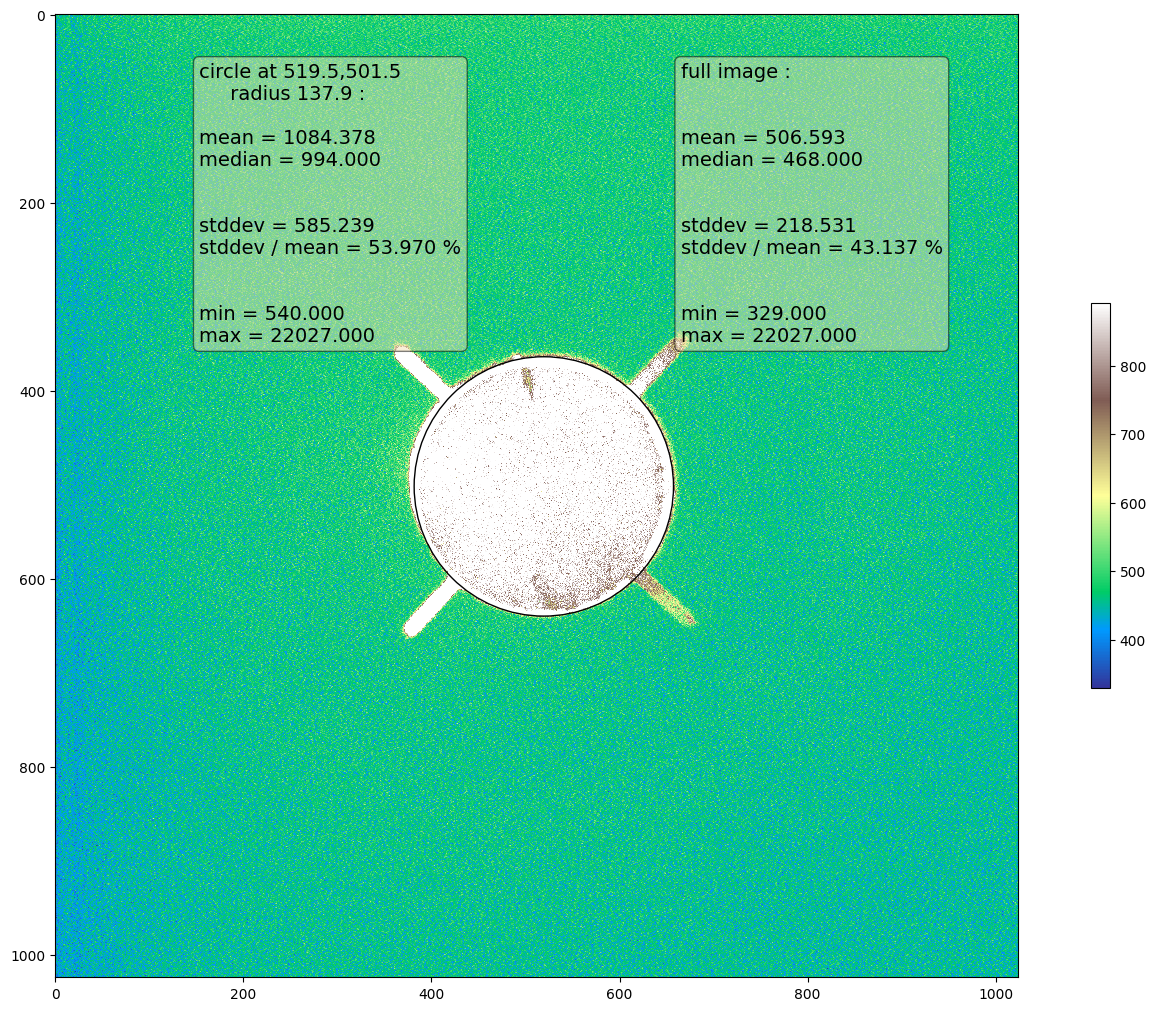

In [14]:
plot_data(lv_data, path='', circle_px=c_old)